## Importing all the dependencies

In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, metrics
import matplotlib.pyplot as plt
%matplotlib inline

## Setting all the constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20
n_classes = 4
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

## Displaying the no. of images present in each class

In [3]:
ds = keras.utils.image_dataset_from_directory(
    '../Tumor',
    batch_size=1
)

count = np.zeros(n_classes)
for image_batch, labels_batch in ds.take(len(ds)):
    count[labels_batch.numpy()] += 1

for i in range(n_classes):
    print(f"{ds.class_names[i]} has", int(count[i]), 'images')

Found 21672 files belonging to 4 classes.
Normal has 3066 images
glioma_tumor has 6307 images
meningioma_tumor has 6391 images
pituitary_tumor has 5908 images


## Importing data into tensorflow dataset object

In [4]:
dataset = keras.utils.image_dataset_from_directory(
    '../Tumor',
    seed=1,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 21672 files belonging to 4 classes.


In [5]:
len(dataset)

678

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 0 3 0 1 1 2 1 3 3 2 1 2 1 3 1 2 3 0 2 0 1 0 2 3 1 3 2 0 3 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

## Visualizing some of the images from our dataset

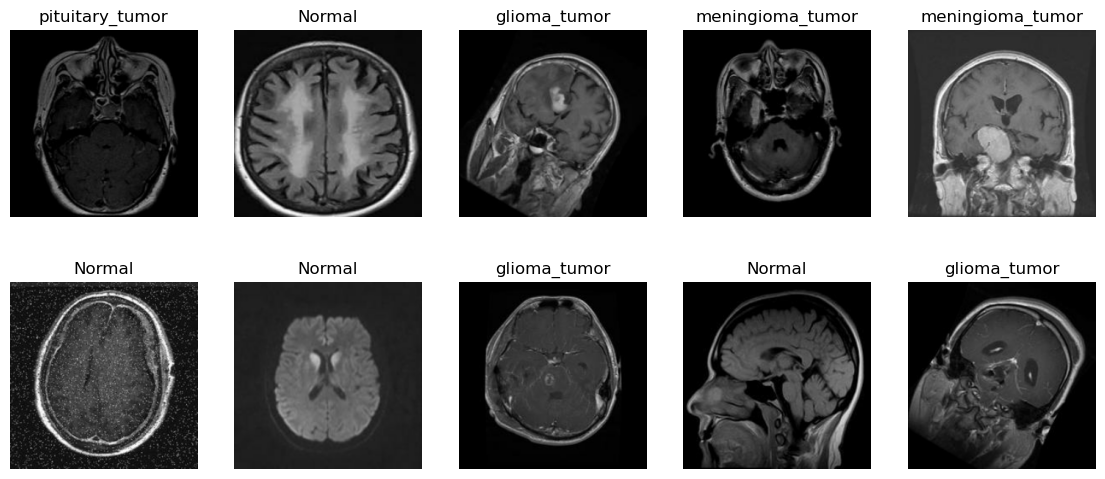

In [7]:
plt.figure(figsize=(14, 6))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(dataset.class_names[labels_batch[i]])
        plt.axis('off')

## Function to create partitions in dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training (75%)         
Validation: Dataset to be tested against while training (10%)         
Test: Dataset to be tested against after we trained a model (15%)

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.1, test_split=0.15, shuffle=True, shuffle_size=2000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)  # train dataset
    val_ds = ds.skip(train_size).take(val_size)  # validation dataset
    test_ds = ds.skip(train_size).skip(val_size)  # test dataset
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds), len(val_ds), len(test_ds)

(508, 67, 103)

## Cache, shuffle, and prefetch the dataset (to get optimized training, validation and test datasets)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to the network, we should resize it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

We have to resize (256, 256) image to again (256, 256). This will be useful when we are done with the training and start using the model for predictions. At that time, someone can supply an image that is not (256, 256) and this layer will resize it.

In [11]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## Data Augmentation
Data augmentation boosts the accuracy of our model by augmenting the data

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

## Applying data augmentation to train dataset

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## 1) Custom CNN model architecture

We have used a Custom CNN model architecture coupled with a `softmax` activation in the output layer and `relu` as an activation function. We have also added the initial layers for resizing and normalization and a dropout layer to avoid overfitting.

In [14]:
custom_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

custom_model.build(input_shape=input_shape)

In [15]:
custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 32)         

## Compiling Custom CNN model

We have used `adam` optimizer, `SparseCategoricalCrossentropy` for losses, and `accuracy` as a metric

In [16]:
custom_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training Custom CNN model for 20 epochs

In [17]:
custom_train_start = time.time()

custom_cnn = custom_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS
)

custom_training_time = int(time.time() - custom_train_start)

Epoch 1/20
508/508 [==============================] - 154s 237ms/step - loss: 1.0134 - accuracy: 0.5577 - val_loss: 0.7557 - val_accuracy: 0.6777
Epoch 2/20
508/508 [==============================] - 62s 122ms/step - loss: 0.7361 - accuracy: 0.6983 - val_loss: 0.4809 - val_accuracy: 0.8232
Epoch 3/20
508/508 [==============================] - 64s 125ms/step - loss: 0.5032 - accuracy: 0.8074 - val_loss: 0.3833 - val_accuracy: 0.8633
Epoch 4/20
508/508 [==============================] - 63s 124ms/step - loss: 0.3982 - accuracy: 0.8478 - val_loss: 0.2942 - val_accuracy: 0.8932
Epoch 5/20
508/508 [==============================] - 64s 127ms/step - loss: 0.3179 - accuracy: 0.8844 - val_loss: 0.2042 - val_accuracy: 0.9305
Epoch 6/20
508/508 [==============================] - 64s 125ms/step - loss: 0.2830 - accuracy: 0.8937 - val_loss: 0.2121 - val_accuracy: 0.9193
Epoch 7/20
508/508 [==============================] - 66s 130ms/step - loss: 0.2590 - accuracy: 0.9036 - val_loss: 0.1938 - val_a

## Evaluating Custom CNN model

In [18]:
custom_eval_start = time.time()

custom_scores = custom_model.evaluate(test_ds)

custom_eval_time = round(time.time() - custom_eval_start)

103/103 [==============================] - 55s 33ms/step - loss: 0.0665 - accuracy: 0.9785


Scores is a list containing evaluation loss and test accuracy value

## Plotting the accuracy and loss curves for Custom CNN model

In [19]:
custom_acc = custom_cnn.history['accuracy']
custom_val_acc = custom_cnn.history['val_accuracy']

custom_loss = custom_cnn.history['loss']
custom_val_loss = custom_cnn.history['val_loss']

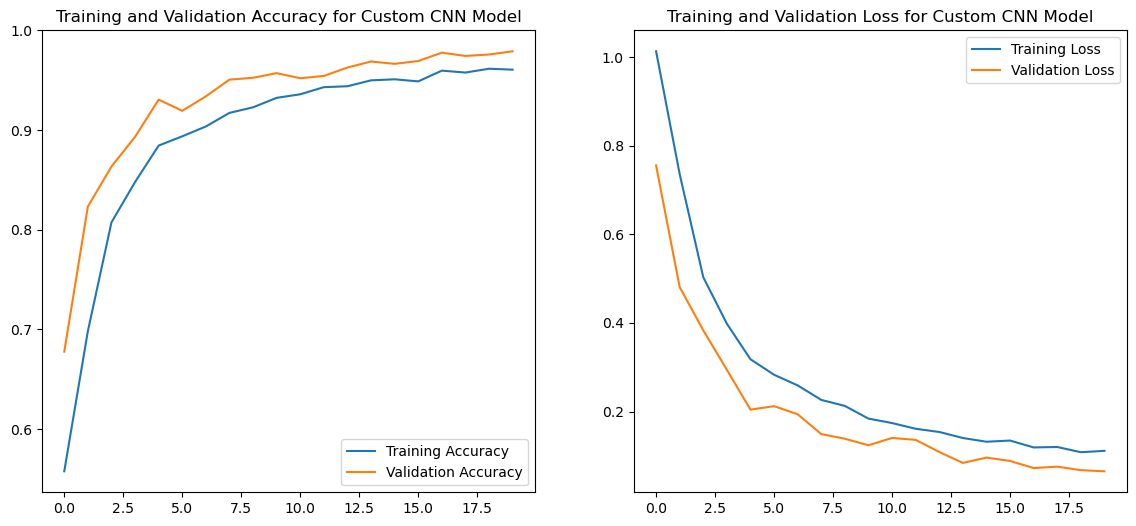

In [20]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), custom_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), custom_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for Custom CNN Model')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), custom_loss, label='Training Loss')
plt.plot(range(EPOCHS), custom_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for Custom CNN Model')
plt.show()

## 2) AlexNet model architecture

We have used an AlexNet model architecture coupled with a `softmax` activation in the output layer and `relu` as an activation function. We have also added the initial layers for resizing and normalization and a dropout layer to avoid overfitting.

In [21]:
alexnet_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

alexnet_model.build(input_shape=input_shape)

In [22]:
alexnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (32, 62, 62, 96)          34944     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 30, 30, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 30, 30, 256)         614656    
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 14, 14, 256)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 14, 14, 384)        

## Compiling AlexNet model

We have used `adam` optimizer, `SparseCategoricalCrossentropy` for losses, and `accuracy` as a metric

In [23]:
alexnet_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training AlexNet model for 20 epochs

In [24]:
alexnet_train_start = time.time()

alexnet = alexnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS
)

alexnet_training_time = round(time.time() - alexnet_train_start)

Epoch 1/20
508/508 [==============================] - 79s 150ms/step - loss: 1.1984 - accuracy: 0.4594 - val_loss: 0.8742 - val_accuracy: 0.6143
Epoch 2/20
508/508 [==============================] - 70s 137ms/step - loss: 0.9060 - accuracy: 0.6113 - val_loss: 0.8156 - val_accuracy: 0.6371
Epoch 3/20
508/508 [==============================] - 71s 140ms/step - loss: 0.7781 - accuracy: 0.6704 - val_loss: 0.6131 - val_accuracy: 0.7612
Epoch 4/20
508/508 [==============================] - 73s 144ms/step - loss: 0.6983 - accuracy: 0.7130 - val_loss: 0.5207 - val_accuracy: 0.7938
Epoch 5/20
508/508 [==============================] - 75s 147ms/step - loss: 0.6150 - accuracy: 0.7526 - val_loss: 0.4544 - val_accuracy: 0.8153
Epoch 6/20
508/508 [==============================] - 74s 145ms/step - loss: 0.5591 - accuracy: 0.7737 - val_loss: 0.4499 - val_accuracy: 0.8218
Epoch 7/20
508/508 [==============================] - 74s 146ms/step - loss: 0.5012 - accuracy: 0.8009 - val_loss: 0.4099 - val_ac

## Evaluating AlexNet model

In [25]:
alexnet_eval_start = time.time()

alexnet_scores = alexnet_model.evaluate(test_ds)

alexnet_eval_time = round(time.time() - alexnet_eval_start)

103/103 [==============================] - 11s 110ms/step - loss: 0.1709 - accuracy: 0.9369


## Plotting the accuracy and loss curves for AlexNet model

In [26]:
alexnet_acc = alexnet.history['accuracy']
alexnet_val_acc = alexnet.history['val_accuracy']

alexnet_loss = alexnet.history['loss']
alexnet_val_loss = alexnet.history['val_loss']

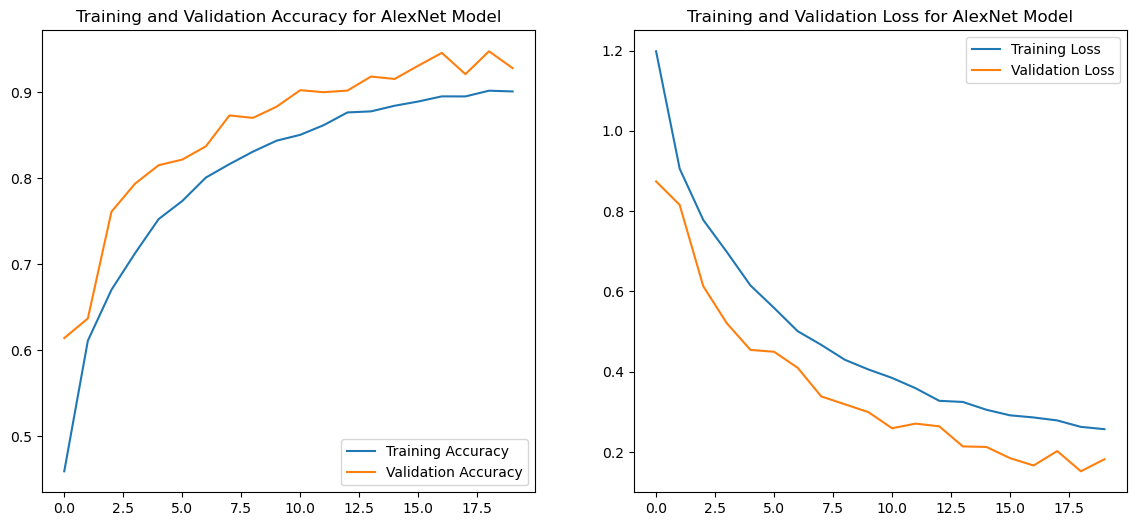

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), alexnet_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), alexnet_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for AlexNet Model')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), alexnet_loss, label='Training Loss')
plt.plot(range(EPOCHS), alexnet_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for AlexNet Model')
plt.show()

## 3) LeNet-5 model architecture

We have used a LeNet-5 model architecture coupled with a `softmax` activation in the output layer and `relu` as an activation function. We have also added the initial layers for resizing and normalization and a dropout layer to avoid overfitting.

In [28]:
lenet5_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

lenet5_model.build(input_shape=input_shape)

In [29]:
lenet5_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (32, 252, 252, 6)         456       
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 126, 126, 6)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (32, 122, 122, 16)        2416      
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 61, 61, 16)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (32, 61, 61, 16)         

## Compiling LeNet-5 model

We have used `adam` optimizer, `SparseCategoricalCrossentropy` for losses, and `accuracy` as a metric

In [30]:
lenet5_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training LeNet-5 model for 20 epochs

In [31]:
lenet5_train_start = time.time()

lenet5 = lenet5_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS
)

lenet5_training_time = round(time.time() - lenet5_train_start)

Epoch 1/20
508/508 [==============================] - 79s 155ms/step - loss: 1.1012 - accuracy: 0.5093 - val_loss: 0.9077 - val_accuracy: 0.6063
Epoch 2/20
508/508 [==============================] - 71s 140ms/step - loss: 0.8965 - accuracy: 0.6129 - val_loss: 0.7807 - val_accuracy: 0.6628
Epoch 3/20
508/508 [==============================] - 64s 126ms/step - loss: 0.7949 - accuracy: 0.6677 - val_loss: 0.7167 - val_accuracy: 0.7099
Epoch 4/20
508/508 [==============================] - 66s 130ms/step - loss: 0.7290 - accuracy: 0.6955 - val_loss: 0.6088 - val_accuracy: 0.7561
Epoch 5/20
508/508 [==============================] - 68s 134ms/step - loss: 0.6697 - accuracy: 0.7225 - val_loss: 0.5984 - val_accuracy: 0.7621
Epoch 6/20
508/508 [==============================] - 69s 136ms/step - loss: 0.6032 - accuracy: 0.7575 - val_loss: 0.5174 - val_accuracy: 0.8055
Epoch 7/20
508/508 [==============================] - 64s 126ms/step - loss: 0.5633 - accuracy: 0.7727 - val_loss: 0.5214 - val_ac

## Evaluating LeNet-5 model

In [32]:
lenet5_eval_start = time.time()

lenet5_scores = lenet5_model.evaluate(test_ds)

lenet5_eval_time = round(time.time() - lenet5_eval_start)

103/103 [==============================] - 11s 103ms/step - loss: 0.2360 - accuracy: 0.9135


## Plotting the accuracy and loss curves for LeNet-5 model

In [33]:
lenet5_acc = lenet5.history['accuracy']
lenet5_val_acc = lenet5.history['val_accuracy']

lenet5_loss = lenet5.history['loss']
lenet5_val_loss = lenet5.history['val_loss']

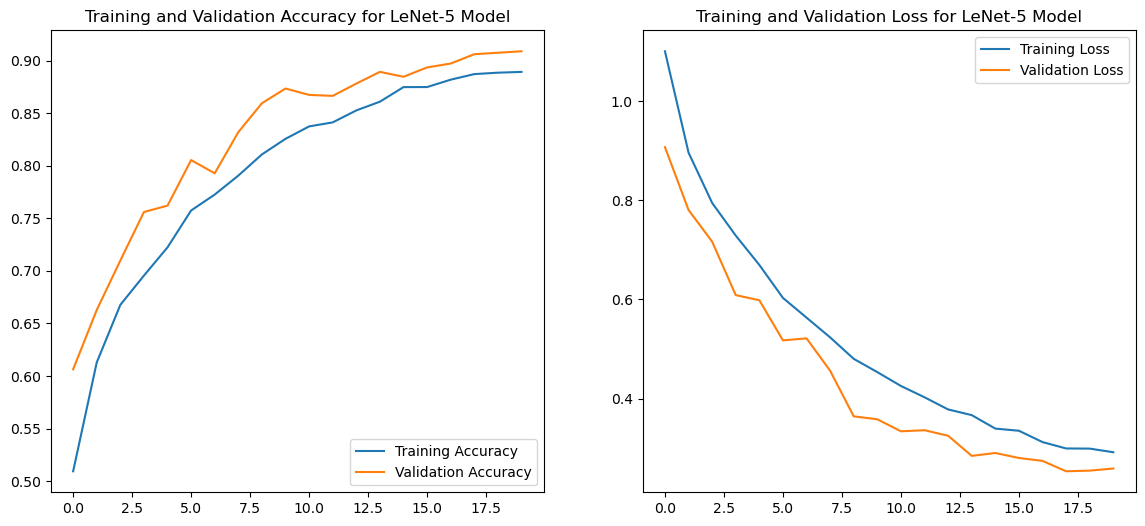

In [34]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), lenet5_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), lenet5_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for LeNet-5 Model')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), lenet5_loss, label='Training Loss')
plt.plot(range(EPOCHS), lenet5_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LeNet-5 Model')
plt.show()

## 4) ResNet model architecture

We have used a ResNet model architecture coupled with a `softmax` activation in the output layer and `relu` as an activation function. We have also added the initial layers for resizing and normalization and a dropout layer to avoid overfitting.

In [35]:
# Define Residual Block
def residual_block(x, filters, strides=1, activation='relu'):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

In [36]:
# Define ResNet model
def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    x = layers.Rescaling(scale=1./255)(x)
    x = layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Stack residual blocks
    x = residual_block(x, filters=16)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, filters=32, strides=2)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, filters=64, strides=2)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, filters=128, strides=2)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

resnet_model = ResNet(input_shape=input_shape[1:], num_classes=n_classes)
resnet_model.build(input_shape=input_shape)

In [37]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 128, 128, 8)  0          ['conv2d_12[0][0]']              
 )                                                                                                
                                                                                              

## Compiling ResNet model

We have used `adam` optimizer, `SparseCategoricalCrossentropy` for losses, and `accuracy` as a metric

In [38]:
resnet_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training ResNet model for 20 epochs

In [39]:
resnet_train_start = time.time()

resnet = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS
)

resnet_training_time = round(time.time() - resnet_train_start)

Epoch 1/20
508/508 [==============================] - 77s 146ms/step - loss: 0.9949 - accuracy: 0.5768 - val_loss: 1.0660 - val_accuracy: 0.5159
Epoch 2/20
508/508 [==============================] - 72s 142ms/step - loss: 0.6896 - accuracy: 0.7202 - val_loss: 0.6126 - val_accuracy: 0.7668
Epoch 3/20
508/508 [==============================] - 71s 139ms/step - loss: 0.5219 - accuracy: 0.7958 - val_loss: 0.4945 - val_accuracy: 0.8102
Epoch 4/20
508/508 [==============================] - 69s 136ms/step - loss: 0.4214 - accuracy: 0.8406 - val_loss: 0.7853 - val_accuracy: 0.7071
Epoch 5/20
508/508 [==============================] - 68s 135ms/step - loss: 0.3507 - accuracy: 0.8677 - val_loss: 0.9584 - val_accuracy: 0.6898
Epoch 6/20
508/508 [==============================] - 68s 134ms/step - loss: 0.3114 - accuracy: 0.8823 - val_loss: 0.5324 - val_accuracy: 0.7924
Epoch 7/20
508/508 [==============================] - 68s 134ms/step - loss: 0.2642 - accuracy: 0.9051 - val_loss: 0.3618 - val_ac

## Evaluating ResNet model

In [40]:
resnet_eval_start = time.time()

resnet_scores = resnet_model.evaluate(test_ds)

resnet_eval_time = round(time.time() - resnet_eval_start)

103/103 [==============================] - 11s 110ms/step - loss: 0.3698 - accuracy: 0.8871


## Plotting the accuracy and loss curves for ResNet model

In [41]:
resnet_acc = resnet.history['accuracy']
resnet_val_acc = resnet.history['val_accuracy']

resnet_loss = resnet.history['loss']
resnet_val_loss = resnet.history['val_loss']

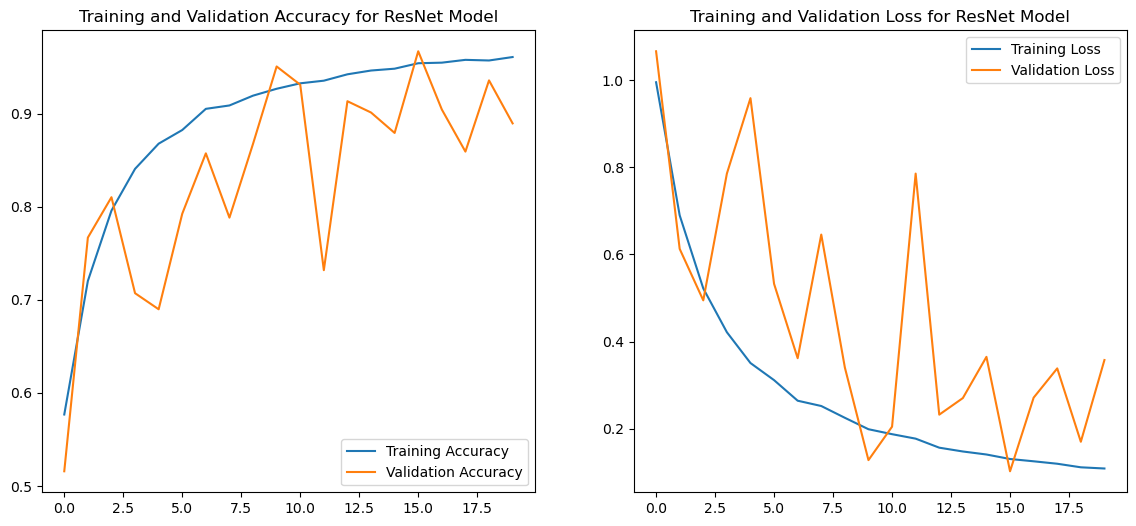

In [42]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), resnet_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), resnet_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for ResNet Model')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), resnet_loss, label='Training Loss')
plt.plot(range(EPOCHS), resnet_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for ResNet Model')
plt.show()

## Formatting the time, accuracy and loss values for better representation

In [43]:
def format_time(sec): # Convert training time to minutes and seconds format
    min = sec // 60
    sec = sec - (min * 60)
    return f"{min}m {sec}s"

custom_train_time = format_time(custom_training_time)
lenet5_train_time = format_time(lenet5_training_time)
alexnet_train_time = format_time(alexnet_training_time)
resnet_train_time = format_time(resnet_training_time)

In [44]:
def format_values(values): # Organize the accuracy and loss values
    return [round(value * 100, 2) if i % 2 != 0 else round(value, 2) for i, value in enumerate(values)]

custom_df = pd.DataFrame(custom_cnn.history)
custom_list = custom_df.iloc[-1].tolist()
custom_hist = format_values(custom_list)
custom_score = format_values(custom_scores)

alexnet_df = pd.DataFrame(alexnet.history)
alexnet_list = alexnet_df.iloc[-1].tolist()
alexnet_hist = format_values(alexnet_list)
alexnet_score = format_values(alexnet_scores)

lenet5_df = pd.DataFrame(lenet5.history)
lenet5_list = lenet5_df.iloc[-1].tolist()
lenet5_hist = format_values(lenet5_list)
lenet5_score = format_values(lenet5_scores)

resnet_df = pd.DataFrame(resnet.history)
resnet_list = resnet_df.iloc[-1].tolist()
resnet_hist = format_values(resnet_list)
resnet_score = format_values(resnet_scores)

## Displaying a table presenting the performance metrics and training details for all the models

In [45]:
data = [
    ['Custom CNN', custom_train_time, f'{custom_eval_time}s', f'{custom_hist[1]}%', f'{custom_hist[3]}%', f'{custom_score[1]}%', custom_hist[0], custom_hist[2], custom_score[0]],
    ['AlexNet', alexnet_train_time, f'{alexnet_eval_time}s', f'{alexnet_hist[1]}%', f'{alexnet_hist[3]}%', f'{alexnet_score[1]}%', alexnet_hist[0], alexnet_hist[2], alexnet_score[0]],
    ['LeNet-5', lenet5_train_time, f'{lenet5_eval_time}s', f'{lenet5_hist[1]}%', f'{lenet5_hist[3]}%', f'{lenet5_score[1]}%', lenet5_hist[0], lenet5_hist[2], lenet5_score[0]],
    ['ResNet', resnet_train_time, f'{resnet_eval_time}s', f'{resnet_hist[1]}%', f'{resnet_hist[3]}%', f'{resnet_score[1]}%', resnet_hist[0], resnet_hist[2], resnet_score[0]]
]

col = ['Model Name', 'Training Time', 'Evaluation Time', 'Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Training Loss', 'Validation Loss', 'Evaluation Loss']
table = pd.DataFrame(data, columns=col)
table['Test Accuracy'] = table['Test Accuracy'].str.rstrip('%').astype(str)
table.sort_values('Test Accuracy', ascending=False, inplace=True)
table.reset_index(drop=True, inplace=True)
table.index += 1
table['Test Accuracy'] = table['Test Accuracy'].astype(str) + '%'
table

,Model Name,Training Time,Evaluation Time,Training Accuracy,Validation Accuracy,Test Accuracy,Training Loss,Validation Loss,Evaluation Loss
1,Custom CNN,23m 22s,55s,96.06%,97.9%,97.85%,0.11,0.07,0.07
2,AlexNet,24m 53s,11s,90.11%,92.82%,93.69%,0.26,0.18,0.17
3,LeNet-5,22m 35s,11s,88.94%,90.9%,91.35%,0.29,0.26,0.24
4,ResNet,23m 27s,11s,96.07%,88.95%,88.71%,0.11,0.36,0.37


`Based on the data presented in the table, it is evident that the Custom CNN model outperforms the other models providing an impressive test accuracy of 97.85%. This signifies that the Custom CNN model exhibits superior performance in accurately classifying unseen data compared to the other models evaluated. This highlights its efficacy in capturing intricate patterns within the dataset. Thus, we have selected this model for prediction.`

## Running prediction on a sample image

First image to predict
Actual label: pituitary_tumor
1/1 [==============================] - 0s 397ms/step
Predicted label: pituitary_tumor


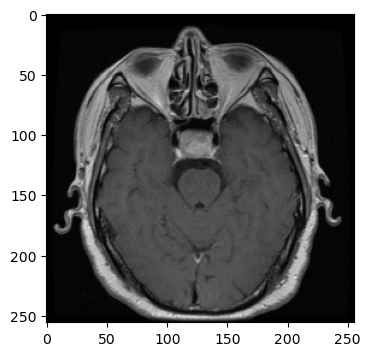

In [46]:
plt.figure(figsize=(5, 4))
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label:', dataset.class_names[first_label])
    
    batch_prediction = custom_model.predict(images_batch)
    print('Predicted label:', dataset.class_names[np.argmax(batch_prediction[0])])

## Defining a function for inference

In [47]:
def predict(custom_model, images):
    img_array = keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = custom_model.predict(img_array)

    predicted_class = dataset.class_names[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

## Running inference on a few sample images

1/1 [==============================] - 0s 12ms/step


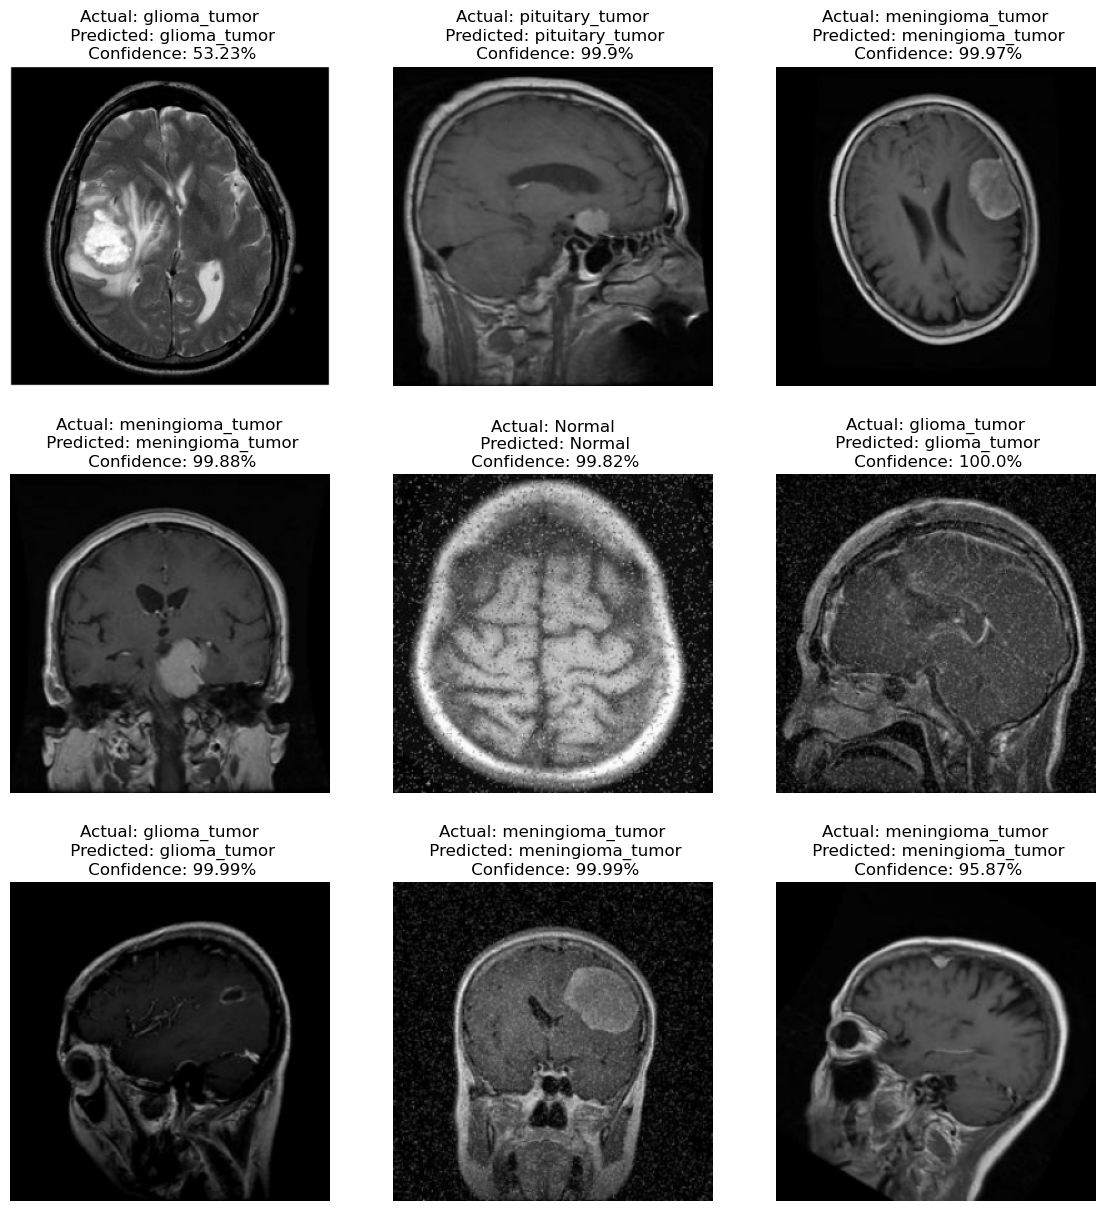

In [48]:
plt.figure(figsize = (14, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(custom_model, images)
        actual_class = dataset.class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis('off')

## Saving the best performing model

We append the model with best accuracy to the list of models as a new version

In [49]:
model_version = max([int(i) for i in os.listdir('./saved_models') + [0]]) + 1
custom_model.save(f"./saved_models/{model_version}")

INFO:tensorflow:Assets written to: ./saved_models/2\assets


INFO:tensorflow:Assets written to: ./saved_models/2\assets
